# 6. 保存和加载模型

_Kevin Siswandi_  
_Deep Learning Nanodegree_

下面学习如何使用 PyTorch 保存和加载模型。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

我们经常需要加载之前训练过的模型，或继续用新的数据训练模型。所以这部分还是挺重要的。

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

下面是一个图像示例。

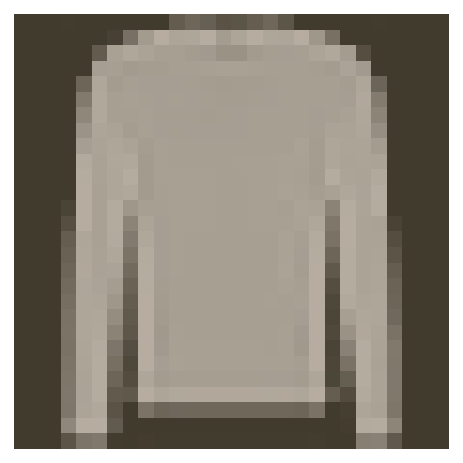

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

下面是上一部分的模型架构和训练代码。

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()


我们可以使用 `Network` 轻松创建一个完全连接的网络，并使用 `train` 训练网络。

In [5]:
# Create the network, define the criterion and optimizer

model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

我会使用经过训练后的模型来演示保存和加载。

In [6]:
train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.645..  Test Loss: 0.954..  Test Accuracy: 0.659
Epoch: 1/2..  Training Loss: 1.012..  Test Loss: 0.740..  Test Accuracy: 0.721
Epoch: 1/2..  Training Loss: 0.843..  Test Loss: 0.707..  Test Accuracy: 0.734
Epoch: 1/2..  Training Loss: 0.801..  Test Loss: 0.650..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.767..  Test Loss: 0.638..  Test Accuracy: 0.753
Epoch: 1/2..  Training Loss: 0.754..  Test Loss: 0.620..  Test Accuracy: 0.774
Epoch: 1/2..  Training Loss: 0.647..  Test Loss: 0.621..  Test Accuracy: 0.761
Epoch: 1/2..  Training Loss: 0.642..  Test Loss: 0.592..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.657..  Test Loss: 0.602..  Test Accuracy: 0.773
Epoch: 1/2..  Training Loss: 0.673..  Test Loss: 0.538..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.621..  Test Loss: 0.552..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.603..  Test Loss: 0.520..  Test Accuracy: 0.808
Epoch: 1/2..  Training Loss: 0.597..  Test Loss: 0.5

每次需要使用网络时都去训练它不太现实，也很不方便。我们可以保存训练过的网络，之后加载这些网络来继续训练或用它们进行预测。

PyTorch 网络的参数保存在模型的 `state_dict` 中。可以看到这个状态字典包含每个层级的权重和偏差矩阵。

In [7]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


最简单的方法是使用 `torch.save` 保存状态字典。例如，我们可以将其保存到文件 `'checkpoint.pth'` 中。

In [8]:
torch.save(model.state_dict(), 'checkpoint.pth')

然后，使用 `torch.load` 加载这个状态字典。

In [9]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


要将状态字典加载到神经网络中，需要执行 `model.load_state_dict(state_dict)`。

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

看上去很简单？其实不然！只有模型结构和检查点的结构完全一样时，状态字典才能加载成功哦。如果我在创建模型时使用了不同的结构，便无法顺利加载。

In [12]:
# Try this
model = Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

这就是说，我们需要重新构建和训练时完全一样的模型。我们需要将模型架构信息与状态字典一起保存在检查点里。所以，你需要创建一个字典，其中包含完全重新构建模型所需的所有信息。

In [13]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

现在，检查点中包含了重建训练模型所需的全部信息。你可以随意将它编写为函数。同样，我们可以编写一个函数来加载检查点。

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [17]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
